### Klasyfikator wieloklasowy - Image Classification - Dog vs. Cat vs. Hamster

1. [Import bibliotek](#a0)
2. [Załadowanie danych](#a1)
3. [Przygotowanie zbiorów: treningowego, walidacyjnego i testowego](#a2)
4. [Eksplorcja danych](#a3)
5. [Augmentacja danych](#a4)
6. [Budowa modelu](#a5)
7. [Transfer learning - model VGG16](#a6)
8. [Transfer learning - model VGG16 - odmrożenie kilku ostatnich warstw](#a7)
9. [Ocena modelu na zbiorze testowym](#a8)
10. [Wyświetlenie błędów predykcji](#a9)

In [ ]:
# Przygotowanie środowiska do pracy z Tensorflow 2.0.
# Jeśli otrzymasz błąd podczas instalacji Tensorflow uruchom tę komórkę raz jeszcze.

!pip uninstall -y tensorflow
!pip install -q tensorflow

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.6 MB/s eta 0:00:00


### <a name='a0'></a> Import bibliotek

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG19

np.set_printoptions(precision=6, suppress=True)

### <a name='a0'></a> usunięcie niepotrzebnego zbioru

In [ ]:
path = './data/cats'
img_to_remove = []
for filename in os.listdir(path):
  image_path = path + '/' + filename
  img_to_remove.append(image_path)

img_to_remove[0]

In [ ]:
for file in img_to_remove:
  if '.jpg' in file and os.path.exists(file):
    os.remove(file)

### <a name='a2'></a> Przygotowanie zbiorów: treningowego, walidacyjnego i testowego

In [2]:
!unzip -q data.zip

In [3]:
base_dir = './data'
raw_no_of_files = {}
classes = ['dog', 'cat', 'hamster']
for dir in classes:
    raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()

dict_items([('dog', 1440), ('cat', 2234), ('hamster', 1320)])

In [4]:
data_dir = './images'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')    # katalog zbioru treningowego
valid_dir = os.path.join(data_dir, 'valid')    # katalog zbioru walidacyjnego
test_dir = os.path.join(data_dir, 'test')      # katalog zbioru testowego

train_dog_dir = os.path.join(train_dir, 'dog')
train_cat_dir = os.path.join(train_dir, 'cat')
train_hamster_dir = os.path.join(train_dir, 'hamster')

valid_dog_dir = os.path.join(valid_dir, 'dog')
valid_cat_dir = os.path.join(valid_dir, 'cat')
valid_hamster_dir = os.path.join(valid_dir, 'hamster')

test_dog_dir = os.path.join(test_dir, 'dog')
test_cat_dir = os.path.join(test_dir, 'cat')
test_hamster_dir = os.path.join(test_dir, 'hamster')

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

dirs = [train_dog_dir, train_cat_dir, train_hamster_dir,
        valid_dog_dir, valid_cat_dir, valid_hamster_dir,
        test_dog_dir, test_cat_dir, test_hamster_dir]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)

In [ ]:
dog_fnames = os.listdir(os.path.join(base_dir, classes[0]))
cat_fnames = os.listdir(os.path.join(base_dir, classes[1]))
hamster_fnames = os.listdir(os.path.join(base_dir, classes[2]))

dog_fnames = [fname for fname in dog_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
cat_fnames = [fname for fname in cat_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
hamster_fnames = [fname for fname in hamster_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

len(dog_fnames), len(cat_fnames), len(hamster_fnames)

In [6]:
size = min(len(dog_fnames), len(cat_fnames), len(hamster_fnames))

train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [7]:
for i, fname in enumerate(dog_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir,  classes[0], fname)
        dst = os.path.join(train_dog_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir,  classes[0], fname)
        dst = os.path.join(valid_dog_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir,  classes[0], fname)
        dst = os.path.join(test_dog_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(cat_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir,  classes[1], fname)
        dst = os.path.join(train_cat_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir,  classes[1], fname)
        dst = os.path.join(valid_cat_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir,  classes[1], fname)
        dst = os.path.join(test_cat_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(hamster_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir,  classes[2], fname)
        dst = os.path.join(train_hamster_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir,  classes[2], fname)
        dst = os.path.join(valid_hamster_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir,  classes[2], fname)
        dst = os.path.join(test_hamster_dir, fname)
        shutil.copyfile(src, dst)

print('dog - zbiór treningowy', len(os.listdir(train_dog_dir)))
print('dog - zbiór walidacyjny', len(os.listdir(valid_dog_dir)))
print('dog - zbiór testowy', len(os.listdir(test_dog_dir)))

print('cat - zbiór treningowy', len(os.listdir(train_cat_dir)))
print('cat - zbiór walidacyjny', len(os.listdir(valid_cat_dir)))
print('cat - zbiór testowy', len(os.listdir(test_cat_dir)))

print('hamster - zbiór treningowy', len(os.listdir(train_hamster_dir)))
print('hamster - zbiór walidacyjny', len(os.listdir(valid_hamster_dir)))
print('hamster - zbiór testowy', len(os.listdir(test_hamster_dir)))

dog - zbiór treningowy 924
dog - zbiór walidacyjny 264
dog - zbiór testowy 132
cat - zbiór treningowy 924
cat - zbiór walidacyjny 264
cat - zbiór testowy 132
hamster - zbiór treningowy 924
hamster - zbiór walidacyjny 264
hamster - zbiór testowy 132


## Eksploracja danych

In [ ]:
#@title Wybierz indeks przykładowego zdjęcia psa ze zbioru treningowego:

idx = 270 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(dog_fnames))
img_path = os.path.join(train_dog_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [ ]:
#@title Wybierz indeks przykładowego zdjęcia psa ze zbioru treningowego:

idx = 840 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(cat_fnames))
img_path = os.path.join(train_cat_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [ ]:
#@title Wybierz indeks przykładowego zdjęcia psa ze zbioru treningowego:

idx = 699 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(hamster_fnames))
img_path = os.path.join(train_hamster_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

##Augmentacja danych

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=40,      # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
    )

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='categorical')

In [9]:
def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = fnames[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

In [ ]:
#@title Zbiór treningowy dog:
idx = 712 #@param {type:'slider', min:0, max:919}
display_augmented_images(train_dog_dir, idx)

##Budowa modelu

In [10]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

## Transfer learning - model VGG19 - odmrożenie kilku ostatnich warstw

In [ ]:
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=1024, activation='relu'))
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=3, activation='softmax'))
model.summary()

In [ ]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

In [14]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(
    monitor='val_accuracy',  # monitorujemy dokładność na zbiorze walidacyjnym
    patience=40,              # liczba epok bez poprawy
    verbose=1                 # opcjonalnie, wyświetla komunikaty
)

In [15]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=200,    # 100
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             callbacks=[early_stopping_monitor])

<ipython-input-15-5782ff77e461>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/200
28/28 [==============================] - 53s 2s/step - loss: 1.1042 - accuracy: 0.3450 - val_loss: 1.1005 - val_accuracy: 0.3359
Epoch 2/200
28/28 [==============================] - 50s 2s/step - loss: 1.0999 - accuracy: 0.3672 - val_loss: 1.0990 - val_accuracy: 0.3320
Epoch 3/200
28/28 [==============================] - 48s 2s/step - loss: 1.0999 - accuracy: 0.3337 - val_loss: 1.0982 - val_accuracy: 0.3203
Epoch 4/200
28/28 [==============================] - 51s 2s/step - loss: 1.0993 - accuracy: 0.3504 - val_loss: 1.1002 - val_accuracy: 0.3789
Epoch 5/200
28/28 [==============================] - 52s 2s/step - loss: 1.0992 - accuracy: 0.3136 - val_loss: 1.0967 - val_accuracy: 0.3398
Epoch 6/200
28/28 [==============================] - 50s 2s/step - loss: 1.1055 - accuracy: 0.3895 - val_loss: 1.0821 - val_accuracy: 0.3789
Epoch 7/200
28/28 [==============================] - 49s 2s/step - loss: 1.0805 - accuracy: 0.3984 - val_loss: 1.0679 - val_accuracy: 0.4336
Epoch 8/200
2

In [17]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

In [27]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

y_prob = model.predict_generator(test_generator, test_generator.samples)
y_prob

Found 396 images belonging to 3 classes.


<ipython-input-27-d5c8c634ffeb>:10: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



array([[0.755895, 0.243216, 0.000889],
       [0.059499, 0.940418, 0.000083],
       [0.      , 0.      , 1.      ],
       ...,
       [0.41386 , 0.543036, 0.043104],
       [0.546398, 0.142775, 0.310826],
       [0.646383, 0.306977, 0.04664 ]], dtype=float32)

In [28]:
y_pred = np.argmax(y_prob, axis=1)
y_pred

array([0, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 2, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       2, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 2, 0, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0,
       0, 0, 2, 2, 2, 1, 2, 2, 0, 1, 0, 2, 1, 2, 2,

In [29]:
predictions  = pd.DataFrame({'class': y_pred})
predictions

,class
0,0
1,1
2,2
3,0
4,0
...,...
391,2
392,2
393,1
394,0


In [30]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [31]:
y_pred = predictions['class'].values
y_pred

array([0, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 2, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       2, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 2, 0, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0,
       0, 0, 2, 2, 2, 1, 2, 2, 0, 1, 0, 2, 1, 2, 2,

In [32]:
test_generator.class_indices

{'cat': 0, 'dog': 1, 'hamster': 2}

In [33]:
classes = list(test_generator.class_indices.keys())
classes

['cat', 'dog', 'hamster']

In [34]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[112,  18,   2],
       [ 50,  79,   3],
       [ 50,  12,  70]])

In [35]:
def plot_confusion_matrix(cm):
    # Mulitclass classification, 3 classes
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=classes, index=classes[::-1])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index), colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()

import plotly.figure_factory as ff
plot_confusion_matrix(cm)

In [36]:
np.sum(cm)

396

In [37]:
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

         cat       0.53      0.85      0.65       132
         dog       0.72      0.60      0.66       132
     hamster       0.93      0.53      0.68       132

    accuracy                           0.66       396
   macro avg       0.73      0.66      0.66       396
weighted avg       0.73      0.66      0.66       396



In [38]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors

,y_true,y_pred
cat/06XVMNEPRA3B.jpg,0,0
cat/08Z6ESIANPEG.jpg,0,1
cat/0IBFWJ5KVW9R.jpg,0,2
cat/0L3FH8OEKP5V.jpg,0,0
cat/0VRTMACBWYXJ.jpg,0,0
...,...,...
hamster/YTUN5SVZFRLX.jpg,2,2
hamster/ZA9WASW8YISD.jpg,2,2
hamster/ZBYGGOCOR96J.jpg,2,1
hamster/ZD11D7Q5KCTK.jpg,2,0


In [39]:
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors[:20]

,y_true,y_pred,is_incorrect
cat/06XVMNEPRA3B.jpg,0,0,0
cat/08Z6ESIANPEG.jpg,0,1,1
cat/0IBFWJ5KVW9R.jpg,0,2,1
cat/0L3FH8OEKP5V.jpg,0,0,0
cat/0VRTMACBWYXJ.jpg,0,0,0
cat/0XCSR5V5ZEAG.jpg,0,0,0
cat/13Z667KCX201.jpg,0,0,0
cat/17MPF2E8O1WR.jpg,0,0,0
cat/1FD32EGCMMT8.jpg,0,1,1
cat/1G3CWV9FKWYM.jpg,0,0,0


In [40]:
# errors[errors['is_incorrect'] == 1].index
results = [[row['y_true'], row['y_pred'], filename] for filename, row in errors.iterrows() if row['is_incorrect'] == 1]
for i in results:
  print(f'true: {i[0]}, pred: {i[1]}, img: {i[2]}')

len(results)

true: 0, pred: 1, img: cat/08Z6ESIANPEG.jpg
true: 0, pred: 2, img: cat/0IBFWJ5KVW9R.jpg
true: 0, pred: 1, img: cat/1FD32EGCMMT8.jpg
true: 0, pred: 1, img: cat/3F5BBILROIRH.jpg
true: 0, pred: 2, img: cat/5H8I5997UTKI.jpg
true: 0, pred: 1, img: cat/5YTAQDOEBN7K.jpg
true: 0, pred: 1, img: cat/AD7659OHB6HT.jpg
true: 0, pred: 1, img: cat/CIKXTGEGN7DV.jpg
true: 0, pred: 1, img: cat/DMQ0PIW1N036.jpg
true: 0, pred: 1, img: cat/GP3EVPQPD7WE.jpg
true: 0, pred: 1, img: cat/K05KSGQ3IUFV.jpg
true: 0, pred: 1, img: cat/KB4N0V7MOZ9M.jpg
true: 0, pred: 1, img: cat/OWUCWFYS4211.jpg
true: 0, pred: 1, img: cat/Q06GH0564O8Z.jpg
true: 0, pred: 1, img: cat/SZJO2IULP7IZ.jpg
true: 0, pred: 1, img: cat/T2MS7G96X5D9.jpg
true: 0, pred: 1, img: cat/U7UUCI3L0E8L.jpg
true: 0, pred: 1, img: cat/V8TWLND27RPU.jpg
true: 0, pred: 1, img: cat/VBEKRZVXOKDD.jpg
true: 0, pred: 1, img: cat/ZAIHRD32E55V.jpg
true: 1, pred: 0, img: dog/n02086079_10627.jpg
true: 1, pred: 0, img: dog/n02086079_17291.jpg
true: 1, pred: 0, img: dog

135

(-0.5, 499.5, 332.5, -0.5)

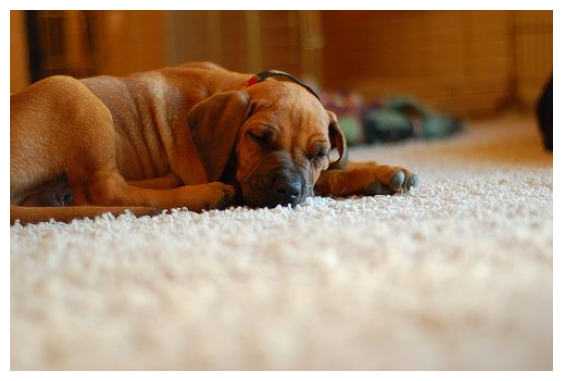

In [43]:
img_path = os.path.join(test_dog_dir, 'n02087394_1743.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

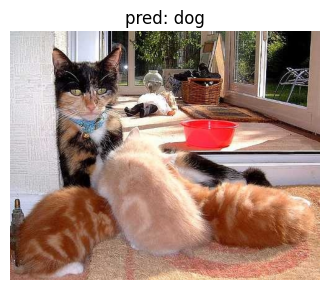

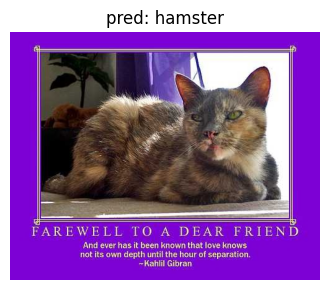

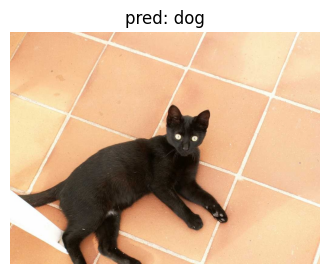

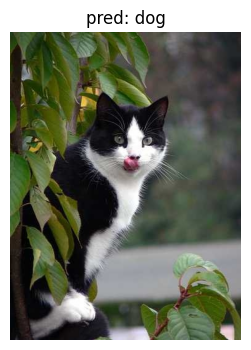

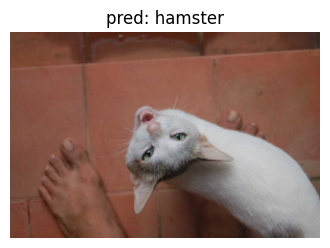

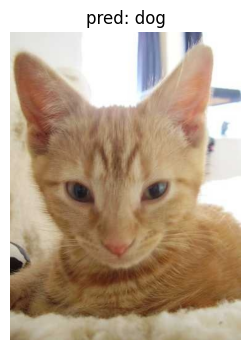

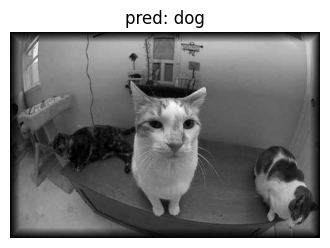

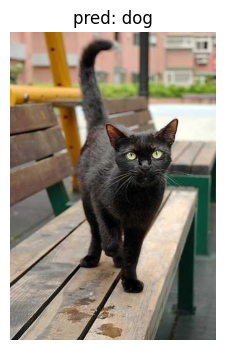

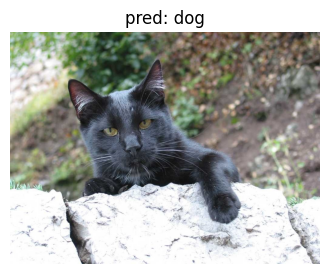

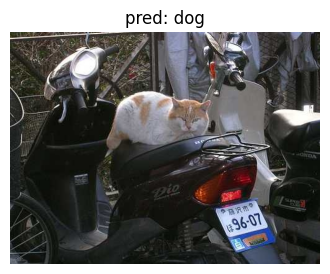

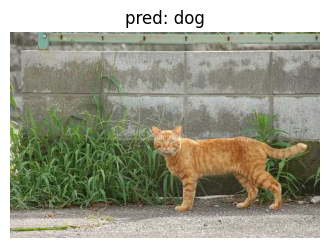

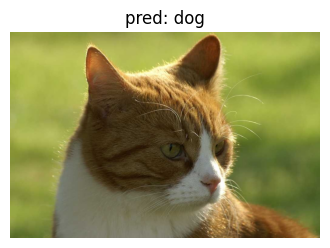

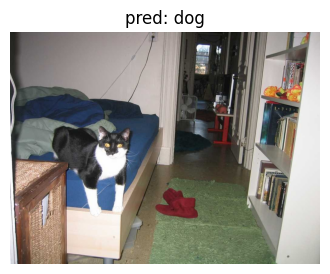

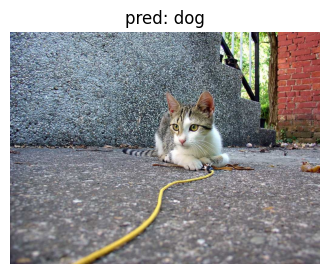

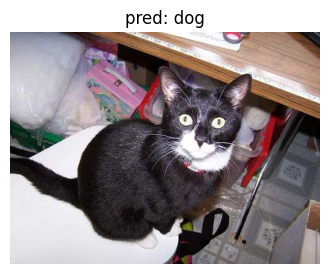

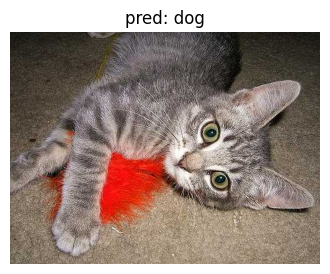

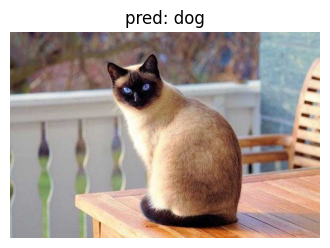

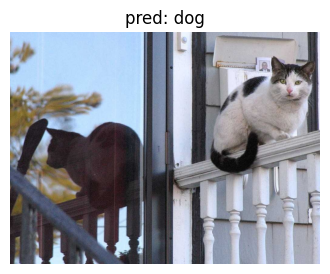

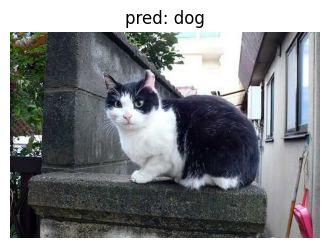

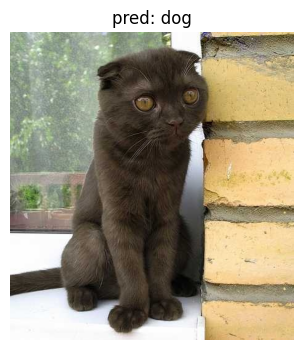

In [46]:
for i in results:
  if i[0] != 0:
    continue

  img_path = os.path.join(test_cat_dir, i[2].split('/')[1])

  img = image.load_img(img_path)

  plt.figure(figsize=(4, 4))
  plt.title('pred: dog' if i[1] == 1 else 'pred: hamster')
  plt.imshow(img)
  plt.grid(False)
  plt.axis(False)

In [45]:
cat_res = 0
for i in results:
  if i[0] != 0:
    continue
  cat_res += 1

cat_res

20